In [127]:
import sklearn
import pandas as pd
from fastai.imports import *
from fastai.structured import *

In [128]:
main_raw = pd.read_csv('/home/orange/MLHoli/Competitions/Data/train.csv')
meal_raw = pd.read_csv('/home/orange/MLHoli/Competitions/Data/meal_info.csv')
center_raw = pd.read_csv('/home/orange/MLHoli/Competitions/Data/fulfilment_center_info.csv')

In [129]:
df_raw = pd.merge(main_raw, meal_raw,how='outer', on='meal_id')

In [130]:
df_raw = pd.merge(df_raw, center_raw, how='outer', on='center_id')

In [131]:
#df_cat = pd.get_dummies(df_raw, columns=['meal_id', 'center_id', 'emailer_for_promotion', 'homepage_featured', 'category', 'cuisine', 'center_type'])

In [132]:
df_cat = df_raw

In [133]:
df_cat['week_mod4'] = df_cat.week % 4

In [135]:
df_cat['month'] = df_cat.week / 4

In [136]:
df_cat['month'] = df_cat['month'].astype('int')

In [137]:
df_cat['week_mod52'] = df_cat.week % 52

In [138]:
df_cat['discount'] = df_cat.base_price - df_cat.checkout_price

In [139]:
df_cat['discount_percent'] = df_cat.discount *100 / df_cat.base_price

In [140]:
df_cat.drop('id', axis=1, inplace=True)

In [141]:
df_cat.drop('week', axis=1, inplace=True)

In [142]:
df_cat.dtypes

center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
category                  object
cuisine                   object
city_code                  int64
region_code                int64
center_type               object
op_area                  float64
week_mod4                  int64
month                      int64
week_mod52                 int64
discount                 float64
discount_percent         float64
dtype: object

In [143]:
train_cats(df_cat)

In [144]:
df_trn, y_trn, nas = proc_df(df_cat, 'num_orders')

In [145]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

size_train = int(len(df_trn)*0.7)
x_train, x_valid = split_vals(df_trn, size_train)
y_train, y_valid = split_vals(y_trn, size_train)

In [148]:
def print_score(m):
    return metrics.mean_squared_log_error(y_valid, m.predict(x_valid))*100

In [147]:
m = ensemble.RandomForestRegressor(n_jobs=-1, max_features=0.3, min_samples_leaf=3, n_estimators=60, oob_score=False)
m.fit(x_train, y_train)
print_score(m)

ValueError: Number of features of the model must match the input. Model n_features is 17 and input n_features is 9 

In [149]:
print_score(m)

42.55890012677851

In [151]:
fi = rf_feat_importance(m, x_train)

In [152]:
fi[:25]

,cols,imp
2,checkout_price,0.135297
6,category,0.115012
3,base_price,0.094906
1,meal_id,0.094872
11,op_area,0.086069
5,homepage_featured,0.072693
7,cuisine,0.061275
4,emailer_for_promotion,0.059299
16,discount_percent,0.052910
0,center_id,0.045349


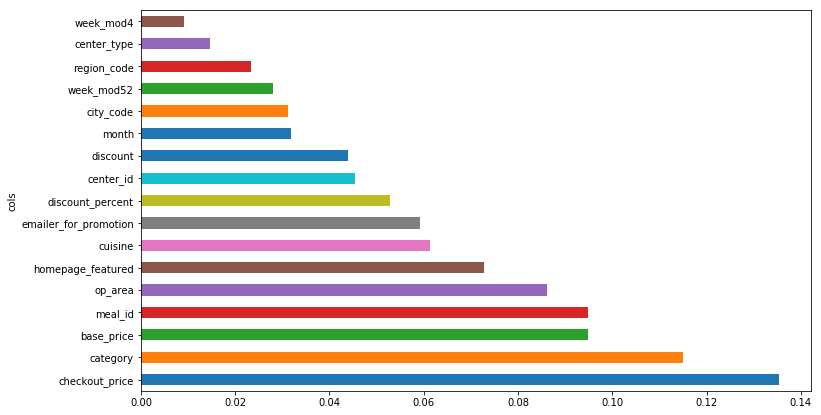

In [153]:
def plot_fi(fi): 
  return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [121]:
to_keep = fi[fi.imp>0.05].cols;

df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, size_train)

m = ensemble.RandomForestRegressor(n_estimators=60, min_samples_leaf=2, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

51.71406557492866